## Task 0: import data

1. Create folder called data next to main.ipynb
1. Create file called .gitignore next to main.ipynb. In this write: data/
1. Download data between 01-01-2021 and 01-01-2022
    1. Nordpool - hourly prices in DKK
    1. Bornholm network manager - kirkeby Sose Vindpark Active Power
    1. Digital Energy Lab/Weather Observations/DMI - All streams from Bornholm
1. Place data files under /data and rename to production, prices, and weather

## Task 1: Optimization model

In [23]:
import gurobipy as gp
from gurobipy import GRB
import random

# Create optimization model for bidding strategy in DA and balancing market
# Probably good to write it as a class or function for easier repeated use 

#### Set parameters ####
t = 24
C = 500 ### OBS FORKERT!!!!!!!!


# Fixed price and production arrays

lambda_DA = [65.3, 72.1, 80.5, 67.8, 55.9, 64.2, 78.4, 71.3, 85.1, 90.5, 63.4, 70.9, 
             68.1, 75.6, 83.3, 69.4, 61.2, 66.7, 76.5, 82.2, 59.8, 72.4, 88.0, 73.9]  # Day-ahead market prices (EUR/MWh)

lambda_up = [9.4, 11.3, 130.5, 10.9, 90.8, 108.2, 115.9, 103.4, 128.5, 132.2, 104.1, 
             109.6, 120.7, 112.3, 138.4, 121.9, 109.3, 118.7, 126.8, 137.5, 102.5, 
             116.9, 141.6, 115.4]  # Upward regulation prices (EUR/MWh)

lambda_down = [25.4, 32.6, 45.2, 30.1, 23.9, 27.8, 33.7, 31.4, 40.5, 38.1, 27.2, 35.4, 
               29.3, 31.9, 44.1, 36.7, 26.4, 34.7, 41.5, 39.9, 28.5, 37.6, 43.7, 33.1]  # Downward regulation prices (EUR/MWh)

P_proj = [82.3, 77.4, 92.1, 84.6, 65.2, 70.1, 88.3, 79.5, 90.9, 95.4, 69.8, 83.2, 
          76.9, 81.7, 89.2, 85.0, 67.5, 73.8, 91.1, 94.5, 62.3, 78.9, 93.4, 81.5]  # Realized production (MW)

def market_bid(lambda_DA, lambda_up, lambda_down, P_proj, t = 24, C = 500):
    #### Create model ####
    model = gp.Model()

    #### Decision variables ####
    # Production/bid in DA market
    P_bid = model.addVars(t, lb = 0, ub = C, vtype=GRB.CONTINUOUS, name="P_bid")

    # Binary variables for upward and downward regulation
    u = model.addVars(t, vtype=GRB.BINARY, name="upward_regulation")  # Binary for upward regulation
    d = model.addVars(t, vtype=GRB.BINARY, name="downward_regulation")  # Binary for downward regulation

    #### Set Constraints ####
    # Ensure that in each hour, the wind farm cannot be paid for both upward and downward regulation
    model.addConstrs((u[i] + d[i] <= 1 for i in range(t)), "up_or_down")

    # Ensure that the wind farm is either in upward or downward regulation. ## Are both needed? ##
    model.addConstrs((u[i] + d[i] == 1 for i in range(t)), "regulation")

    # Only allow upward or downward regulation to be non-zero when the respective binary is active.  ## Not sure that these are binding ##
    model.addConstrs((lambda_up[i] * (P_bid[i] - P_proj[i]) * u[i] >= 0 for i in range(t)), "upward_nonzero")
    model.addConstrs((lambda_down[i] * (P_proj[i] - P_bid[i]) * d[i] >= 0 for i in range(t)), "downward_nonzero")


    #### Set Objective ####
    model.setObjective(
        gp.quicksum(lambda_DA[i] * P_bid[i] for i in range(t)) + 
        gp.quicksum(lambda_down[i] * (P_proj[i] - P_bid[i]) * d[i] - lambda_up[i] * (P_bid[i] - P_proj[i]) * u[i] for i in range(t)),
        GRB.MAXIMIZE
    )

    #### Optimize ####
    model.setParam('OutputFlag', 0)
    model.optimize()


    #### Print results ####
    print("Optimal production/bid in DA market")
    for i in range(t):
        print(f"t={i}: Bid: {P_bid[i].x}  Projected: {P_proj[i]} Day-ahead price: {lambda_DA[i]} Upward price: {lambda_up[i]} Downward price: {lambda_down[i]}  Binary up: {u[i].x}  Binary down: {d[i].x}")

    print("Objective value")
    print(model.objVal)

    return model.getAttr("X", P_bid)

P_bid = market_bid(lambda_DA, lambda_up, lambda_down, P_proj)



Optimal production/bid in DA market
t=0: Bid: 500.0  Projected: 82.3 Day-ahead price: 65.3 Upward price: 9.4 Downward price: 25.4  Binary up: 1.0  Binary down: 0.0
t=1: Bid: 500.0  Projected: 77.4 Day-ahead price: 72.1 Upward price: 11.3 Downward price: 32.6  Binary up: 1.0  Binary down: 0.0
t=2: Bid: 92.1  Projected: 92.1 Day-ahead price: 80.5 Upward price: 130.5 Downward price: 45.2  Binary up: 0.0  Binary down: 1.0
t=3: Bid: 500.0  Projected: 84.6 Day-ahead price: 67.8 Upward price: 10.9 Downward price: 30.1  Binary up: 1.0  Binary down: 0.0
t=4: Bid: 65.2  Projected: 65.2 Day-ahead price: 55.9 Upward price: 90.8 Downward price: 23.9  Binary up: 0.0  Binary down: 1.0
t=5: Bid: 70.1  Projected: 70.1 Day-ahead price: 64.2 Upward price: 108.2 Downward price: 27.8  Binary up: 0.0  Binary down: 1.0
t=6: Bid: 88.3  Projected: 88.3 Day-ahead price: 78.4 Upward price: 115.9 Downward price: 33.7  Binary up: 0.0  Binary down: 1.0
t=7: Bid: 79.5  Projected: 79.5 Day-ahead price: 71.3 Upward pr

## Task 2: Data collection

Want to determine some features that we believe will be useful predictors of future wind power. Could be previous wind power, features of the weather, season or similar. 

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from statsmodels.graphics import tsaplots
from sklearn.preprocessing import StandardScaler

# Import and format relevant data 
# Import production data
production = pd.read_csv('data/production.csv')
production['ts'] = pd.to_datetime(production['ts']) # Convert to datetime
production = production.set_index('ts') # Set datetime as index
production = production.resample('h').mean() # Resample to hourly data
production = production.rename(columns={"kirkeby Sose Vindpark Active Power | aki_sov_effekt | 804128": "power"}) # Rename column
production = production.fillna(0) # Fill missing values with 0
production = -1 * production # Change sign to positive for production

# Import weather data
weather = pd.read_csv('data/weather.csv')
weather['ts'] = pd.to_datetime(weather['ts'])
weather = weather.set_index('ts')
weather = weather.resample('h').mean()
weather = weather.fillna(0)

# Import electricity prices
prices = pd.read_csv('data/prices.csv')
prices['ts'] = pd.to_datetime(prices['ts'])
prices = prices.set_index('ts')
prices = prices.rename(columns = {"Nordpool Elspot Prices - hourly price DK-DK2 DKK/MWh | 9F7J/00/00/Nordpool/DK2/hourly_spot_dkk | 4820": "spotprice"})


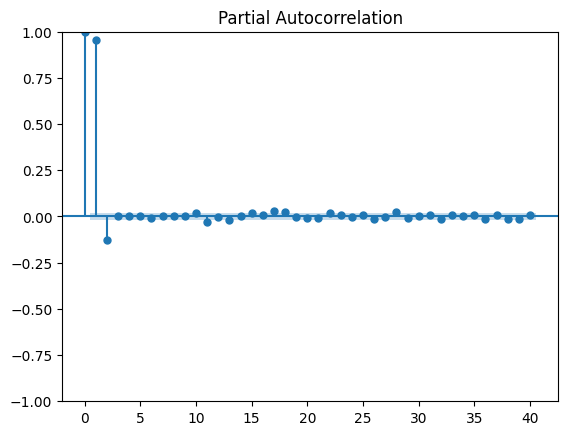

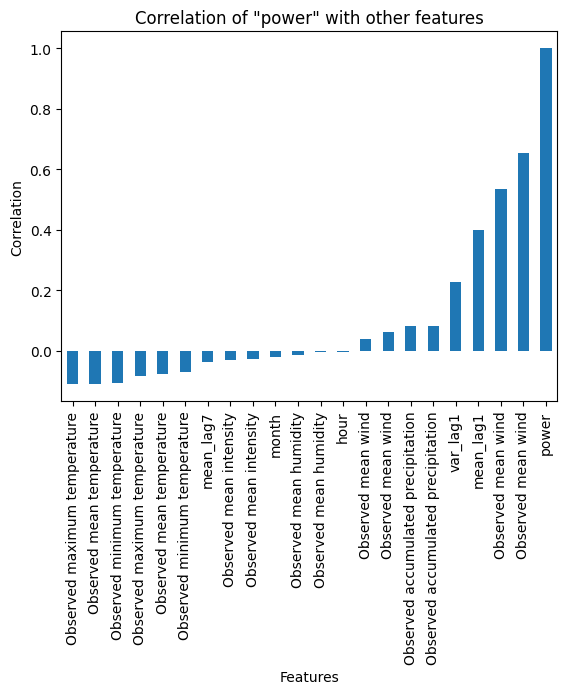

In [41]:
# Check autorrelation of power production
tsaplots.plot_pacf(production)
plt.show()

# Check correlation between features
data = pd.merge(production, weather, left_index=True, right_index=True)

# Shorten the column names to first three words
data.columns = data.columns.str.split().str[:3].str.join(' ')

### Add more potential features ###
# Add hour, day and month as features. Might test later with one-hot encoding
data['hour'] = data.index.hour
data['month'] = data.index.month

# Add mean power production the day before as feature
daily_mean_power = data['power'].resample('D').mean()
mean_lag1 = daily_mean_power.shift(1)
data['mean_lag1'] = data.index.normalize().map(mean_lag1)

# Add variance of power production the day before as feature
daily_var_power = data['power'].resample('D').var()
var_lag1 = daily_var_power.shift(1)
data['var_lag1'] = data.index.normalize().map(var_lag1)

# Add mean power production the week before as feature
weekly_mean_power = data['power'].resample('W').mean()
mean_lag7 = weekly_mean_power.shift(1)
data['mean_lag7'] = data.index.normalize().map(mean_lag7)


data.corr().iloc[:, 0].sort_values().plot(kind='bar')
plt.title('Correlation of "power" with other features')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.xticks(rotation=90)
plt.show()



In [42]:
import numpy as np
from sklearn.preprocessing import StandardScaler


# Choose relevant features
x = np.arange(1000).reshape(-1,1) # Dummy data
y = x + np.random.rand(1000).reshape(-1,1) # Dummy data

# Scale data 
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Add bias term to input data
X = np.concatenate([np.ones((x.shape[0], 1)), x_scaled], axis=1)

# Split data into training and test set for time series data
split_fraction = 0.8
split_index = int(len(x) * split_fraction)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

## Task 3: Linear Regression

In [44]:
from sklearn.linear_model import LinearRegression


# Implement gradient descent

def gradient_descent(X_train, max_iterations=10000, alpha = 0.01):
    # Initial guess of coefficients
    theta = np.zeros(X_train.shape[1])

    # Number of observations
    m = len(X_train)
    
    for _ in range(max_iterations):

        # Linear regression prediction
        h = theta @ X_train.T

        # The partial derivatives of the cost function
        dt = (1/m) * ((h - y_train.T) @ X_train)

        # Update the coefficients
        theta = theta - alpha * dt

        # Break if the change in coefficients is small
        if np.linalg.norm(alpha * dt) < 1e-6:
            return theta
        
    return theta


# Implement closed form solution
theta_cfs = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train

# Compare the two solutions
print(gradient_descent(X_train))
print(theta_cfs)




[[500.00406446 288.68969512]]
[[500.00417672]
 [288.68985282]]


In [45]:
# Evaluate model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Make predictions
y_pred = X_test @ theta_cfs

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2: {r2}")

RMSE: 0.30013170350344476
MAE: 0.25939817092677403
R2: 0.9999729830249975


## Task 4: Non-linear regression

In [29]:
# Implement polynomial regression
from sklearn.preprocessing import PolynomialFeatures

# 4.1: Implement polynomial regression


# 4.2: Implement weighted least squares
# Possible kernels
def gaussian(t):
    return np.exp(-0.5 * t**2) / np.sqrt(2 * np.pi)

def epanechnikov(t):
    kern = np.zeros_like(t)
    kern[np.abs(t) <= 1] = 0.75 * (1 - t[np.abs(t) <= 1]**2)
    return kern

def tricube(t):
    kern = np.zeros_like(t)
    kern[np.abs(t) <= 1] = (70 / 81) * (1 - np.abs(t[np.abs(t) <= 1])**3)**3
    return kern

def uniform(t, p=0.2):
    return np.zeros_like(t) + p

def triangle(t):
    kern = np.zeros_like(t)
    kern[np.abs(t) <= 1] = 1 - np.abs(t[np.abs(t) <= 1])
    return kern


# Implement locally weighted least squares
def lwls(X_train, y_train, X_test, kernel=gaussian, bandwidth=0.1):
    y_pred = np.zeros(X_test.shape[0])
    for i, x in enumerate(X_test):
        # Calculate weights
        weights = kernel(np.linalg.norm(X_train - x, axis=1) / bandwidth)
        W = np.diag(weights)
        
        # Calculate theta
        theta = np.linalg.inv(X_train.T @ W @ X_train) @ X_train.T @ W @ y_train
        
        # Make prediction
        y_pred[i] = x @ theta
        
    return y_pred




## Task 5: Regularization

In [30]:
def lasso(X_train, y_train, alpha=0.1):
    pass

def ridge(X_train, y_train, alpha=0.1):
    return np.linalg.inv(X_train.T @ X_train + alpha * np.eye(X_train.shape[1])) @ X_train.T @ y_train



## Task 6: Revenue calculation for evaluation

In [ ]:
# Psuedo code for evaluating models

# For each model get projections for the next 24 hours
models = [model1, model2, model3]
days = X_test.groupby('day')

revenues = pd.DataFrame(index=days, columns=models)

for model in models:
    for day in test_set:
        bid = market_bid(lambda_DA, lambda_up, lambda_down, P_proj)
        revenue = ...(bid)
        revenues.loc[day, model] = revenue

## Task 7 (optional): Suggestion for improvement

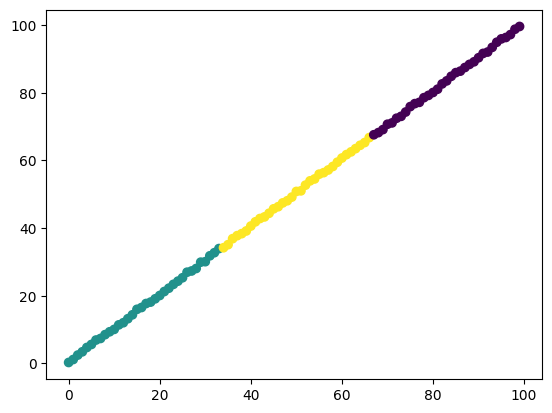

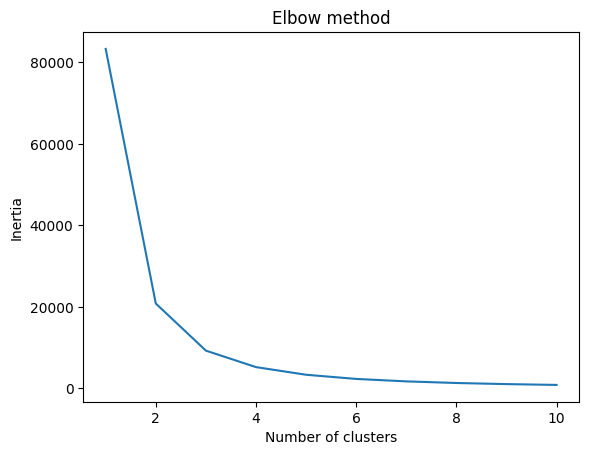

In [31]:
from sklearn.cluster import KMeans


# Implement clustering
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
clusters = kmeans.fit_predict(x).astype('int')

# Plot clusters
plt.scatter(x, y, c=clusters)
plt.show()

# Implement the elbow method to find the optimal number of clusters
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, n_init=10, random_state=42)
    kmeans.fit(x)
    inertia.append(kmeans.inertia_)
plt.plot(range(1, 11), inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow method')
plt.show()

## Task 8: Model 2